In [8]:
#Pytorch 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gpytorch
import botorch 

import matplotlib.pyplot as plt

# Test Plots

### This notebook is used to visualize a GP's prior mean and predictive mean curve against the ground truth and compare them. After fitting a GP curve to data samples, the predictive mean curve is shown to pass through the samples and then return to the prior mean. 

In [1]:
#NN Surrogate model class
from injector_surrogate_quads import *
import physics_gp

sys.path.append('../configs')
#Sim reference point to optimize around
from ref_config import ref_point

/Users/conniexu/opt/anaconda3/envs/baxenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load injector model
Model = Surrogate_NN(pytorch=True)

Model.load_saved_model(model_path = '../models/', 
                       model_name = 'Injector_Surrogate_NN_PyTorch')

Model.load_scaling(scalerfilex = '../data/transformer_x_pytorch.pth', 
                   scalerfiley = '../data/transformer_y_pytorch.pth')
Model.take_log_out = False

In [3]:
beamline_info = json.load(open('../configs/beamline_info.json'))
get_twiss0 = beamline_info['Twiss0']

# emit, beta, alpha
twiss0 = {'x': [get_twiss0[0], get_twiss0[2], get_twiss0[4]],
          'y': [get_twiss0[1], get_twiss0[3], get_twiss0[5]]}

beta0_x, alpha0_x = twiss0['x'][1], twiss0['x'][2]
beta0_y, alpha0_y = twiss0['y'][1], twiss0['y'][2]
print(twiss0['x'])
print(twiss0['y'])

[1e-06, 1.113081026, -0.0689403587]
[1e-06, 1.113021659, -0.07029489754]


In [4]:
# convert to machine units
ref_point = Model.sim_to_machine(np.asarray(ref_point))

# input params: solenoid and quads to vary 
opt_var_names = ['SOL1:solenoid_field_scale','CQ01:b1_gradient', 'SQ01:b1_gradient',
                 "QA01:b1_gradient", "QA02:b1_gradient", 
                 "QE01:b1_gradient", "QE02:b1_gradient", "QE03:b1_gradient", "QE04:b1_gradient"]

bounds = torch.as_tensor([[0.46, 0.485], [-0.02, 0.02], [-0.02, 0.02],
                       [-4, -1], [1, 4],
                       [-7,-1], [-1, 7],[-1, 7], [-7, 1]])

# output params: emittance in transverse plane (x & y)
opt_out_names = ['norm_emit_x','norm_emit_y']

In [5]:
def evaluate(config): 
    """
    D is input space dimensionality
    N is number of sample points
    :param config: input values of opt_var_names, torch.tensor, shape (N, D) 
    returns (N, 1) 
    """
    N = config.shape[0]
    D = config.shape[1]
    
    # make input array of length model_in_list (inputs model takes)
    x_in = torch.empty((N,len(Model.model_in_list)))
    
    # fill in reference point around which to optimize
    x_in[:,:] = torch.tensor(ref_point[0])

    #set solenoid, CQ, SQ, matching quads to values from optimization step
    col = []
    for i in range(D):
        col.append(Model.loc_in[opt_var_names[i]]) #should make col a flat list of indices, e.g. [4, 6, 7]
    x_in[:, col] = config[:,:] 
    
    #output predictions
    y_out = Model.pred_machine_units(x_in)

    return -1*objective(y_out)


def objective(y_out):
    """
    :param y_out: tensor with has a shape of (N, num_outputs)
    returns tensor of emittance * bmag for each input, shape (N, 1)
    """
    
    # geometric emittance in transverse plane
    out1 = y_out[:,Model.loc_out['norm_emit_x']] #grab norm_emit_x out of the model
    out2 = y_out[:,Model.loc_out['norm_emit_y']] #grab norm_emit_y out of the model
    emit = torch.sqrt(out1 * out2)
  
    sigma_x = y_out[:,Model.loc_out['sigma_x']] #grab sigma_x out of the model 
    sigma_y = y_out[:,Model.loc_out['sigma_y']] #grab sigma_y out of the model 
    
    # real beta and alpha 
    # NEEDS TO BE FIXED - currently assuming real alpha to be the same as design alpha 
    alpha_x = torch.tensor(alpha0_x).repeat(y_out.shape[0])
    alpha_y = torch.tensor(alpha0_y).repeat(y_out.shape[0])
    beta_x, beta_y = (sigma_x**2) / out1, (sigma_y**2) / out2
    
    # bmag 
    bmag_x = 0.5 * ((beta0_x / beta_x) + (beta_x / beta0_x)) + 0.5 * ((alpha_x * torch.sqrt(beta0_x / beta_x) - alpha0_x * torch.sqrt(beta_x / beta0_x))**2)
    bmag_y = 0.5 * ((beta0_y / beta_y) + (beta_y / beta0_y)) + 0.5 * ((alpha_y * torch.sqrt(beta0_y / beta_y) - alpha0_y * torch.sqrt(beta_y / beta0_y))**2)
    bmag = torch.sqrt(bmag_x * bmag_y)
    
    out = (emit * bmag)/1e-6 # in um units 
    return out.reshape(-1,1)

## Set up initial training samples

In [9]:
test_param = 6 # from 0 to 8
bounds = torch.as_tensor([[0.46, 0.485], [-0.02, 0.02], [-0.02, 0.02],
                       [-4, -1], [1, 4],
                       [-7,-1], [-1, 7],[-1, 7], [-7, 1]])

# create initial samples within specified bounds
n_samples = 2
n_var = 9

scan_ref_point = torch.cat([torch.as_tensor([ref_point[0][Model.loc_in[param_name]]]) for param_name in opt_var_names])

# self-tune reference point if necessary
scan_ref_point[0] = 0.47645
scan_ref_point[1] = -0.00975
scan_ref_point[2] = 0.00917 
scan_ref_point[3] = -3.79410
scan_ref_point[4] = 2.00556
scan_ref_point[5] = -2.67074
scan_ref_point[6] = 4.38737
scan_ref_point[7] = -0.49207
scan_ref_point[8] = -6.12455


train_x = scan_ref_point.repeat(n_samples, 1) 
train_x[0,test_param] = 3.0
train_x[1,test_param] = 4.0
# train_x[2,test_param] = -1.0
# train_x[3,test_param] = 4.0
# train_x[4,test_param] = 5.0

train_y = evaluate(train_x.float()).detach() # detach gradient to fix going backwards twice error while fitting hyperparameters
print(train_x, train_y)

# transformers 
transformer_x = botorch.models.transforms.input.Normalize(n_var, bounds = bounds.transpose(0,1))
transformer_y = botorch.models.transforms.outcome.Standardize(1)

tensor([[ 0.4764, -0.0097,  0.0092, -3.7941,  2.0056, -2.6707,  3.0000, -0.4921,
         -6.1246],
        [ 0.4764, -0.0097,  0.0092, -3.7941,  2.0056, -2.6707,  4.0000, -0.4921,
         -6.1246]], dtype=torch.float64) tensor([[-0.7931],
        [-1.1189]])


In [10]:
# model 
class NN_prior(nn.Module):
    def __init__(self):
        super(NN_prior, self).__init__()
        
        hidden_size = 40
        self.network = nn.Sequential(nn.Linear(n_var, hidden_size), 
                                     nn.Tanh(), 
                                     nn.Linear(hidden_size, hidden_size), 
                                     nn.Tanh(),
                                     nn.Linear(hidden_size, hidden_size), 
                                     nn.Tanh(),
                                     nn.Linear(hidden_size, hidden_size), 
                                     nn.Tanh(),
                                     nn.Linear(hidden_size, hidden_size), 
                                     nn.Tanh(),
                                     nn.Linear(hidden_size, 1))
        
    def forward(self, x):
        x = self.network(x)
        return x 

In [11]:
# NN model trained from surrogate model samples as prior
from gpytorch.means.mean import Mean
class CustomMean(Mean):
    def __init__(self, name, prior, NN_y_transform, outcome_transform):
        super(CustomMean, self).__init__()
        self.NN_model = prior
        self.NN_model.load_state_dict(torch.load('./results/' + name + '.pth'))
        self.NN_model.eval()
        
        self.NN_model.requires_grad_(False)
        
        self.y_norm_transform = botorch.models.transforms.input.Normalize(1)
        self.y_norm_transform.load_state_dict(torch.load(f'./results/' + NN_y_transform + '.pth'))
        self.y_norm_transform.eval()
        
        self.outcome_transform = outcome_transform
        
    def forward(self, x):
        """
        takes in transformed x, returns transformed y
        """
        self.outcome_transform.eval()
        
        out = []
        if (x.dim() == 2):
            x = x.unsqueeze(dim=0) # shape x into (batch_size = 1, n_samples, n_var) if necessary 
        for i in range(x.size(dim=0)):
            m = self.NN_model(x[i].detach()).float() # normed x |-> NN normed y 
            m = self.y_norm_transform.untransform(m) # NN normed y -> real y
            m = self.outcome_transform(m)[0] # real y -> standardized y
            out.append(m.squeeze())
            
        self.outcome_transform.train()
        return torch.stack(out,dim=0)
    
# surrogate model as prior 
class Surrogate(Mean):
    def __init__(self, input_transform, outcome_transform):
        super(Surrogate, self).__init__()
        self.input_transform = input_transform 
        self.outcome_transform = outcome_transform

    def forward(self, x):
        """
        takes in transformed x, returns transformed y (retaining gradient) 
        """
        self.input_transform.eval()
        self.outcome_transform.eval()
        
        x = self.input_transform.untransform(x) # normed x -> real x 
        out = []
        
        if (x.dim() == 2):
            x = x.unsqueeze(dim=0) # shape x into (batch_size = 1, n_samples, n_var) if necessary 
        for i in range(x.size(dim=0)):
            m = evaluate(x[i].detach()).float() # real x |-> real y
            m = self.outcome_transform(m)[0] # real y -> standardized y
            out.append(m.squeeze())
            
        self.input_transform.train() 
        self.outcome_transform.train()
        return torch.stack(out,dim=0)

## Fit a GP with a Custom (NN) Prior Mean to the Data Samples

In [21]:
# model and its transformer_y
model_name = 'model5_4hidden_40nodes_1000epoch_0.01_-5'
model_transformer_name = 'transformer_y_5^9_-5'

NN_gp = botorch.models.SingleTaskGP(train_x, 
                                    train_y, 
                                    mean_module=CustomMean(model_name, NN_prior(), model_transformer_name, transformer_y),
                                    input_transform=transformer_x,
                                    outcome_transform=transformer_y)

NN_gp.covar_module.base_kernel.lengthscale = 0.1 # to visualize GP curve returning to prior mean 

mll = gpytorch.mlls.ExactMarginalLogLikelihood(NN_GP.likelihood, NN_GP) 

# verify that model parameters are not being trained when tuning GP hyperparameters (network weights and bias gradients should be false)
for name, val in mll.named_parameters():
    print(name, val.requires_grad)

NN_gp.likelihood.noise_covar.noise = torch.tensor(1e-4)

likelihood.noise_covar.raw_noise True
model.mean_module.NN_model.network.0.weight False
model.mean_module.NN_model.network.0.bias False
model.mean_module.NN_model.network.2.weight False
model.mean_module.NN_model.network.2.bias False
model.mean_module.NN_model.network.4.weight False
model.mean_module.NN_model.network.4.bias False
model.mean_module.NN_model.network.6.weight False
model.mean_module.NN_model.network.6.bias False
model.mean_module.NN_model.network.8.weight False
model.mean_module.NN_model.network.8.bias False
model.mean_module.NN_model.network.10.weight False
model.mean_module.NN_model.network.10.bias False
model.covar_module.raw_outputscale True
model.covar_module.base_kernel.raw_lengthscale True


## Plot GP in 1D (Perform a Scan of One Input Variable)

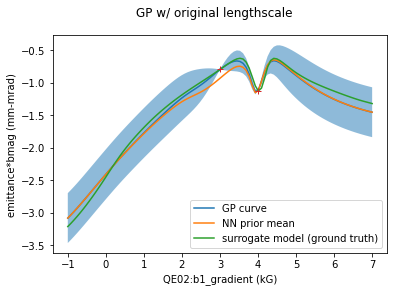

In [23]:
n_test = 100 # number of test input points

# generate input points for parameter scan
test_x = scan_ref_point.repeat(n_test, 1)
test_x[:,test_param] = torch.linspace(bounds[test_param,0],bounds[test_param,1],n_test)

# calculate GP predictive mean function and one std deviation from mean 
with torch.no_grad():
    NN_post = NN_gp.posterior(test_x)
    NN_mean = NN_post.mean
    NN_lower, NN_upper = NN_post.mvn.confidence_region()

# load in original NN model (prior mean) and its transformer to compare it with the GP's predictive mean curve 
# the GP curve should pass through ground truth training samples and return to the NN prior mean 
NN_model = NN_prior()
NN_model.load_state_dict(torch.load(f'./results/{model_name}.pth'))

NN_transformer_y = botorch.models.transforms.input.Normalize(1)
NN_transformer_y.load_state_dict(torch.load(f'./results/' + model_transformer_name + '.pth'))
NN_transformer_y.eval()

# find -emittance*bmag 
normed_prior_test_y = NN_model(transformer_x(test_x).float()) 
prior_test_y = NN_transformer_y.untransform(normed_prior_test_y) # output of NN model
real_test_y = evaluate(test_x.float()).detach() # output of ground truth surrogate model 
                               
fig,ax = plt.subplots()
fig.suptitle('GP w/ original lengthscale', fontsize=12)

ax.set_xlabel(opt_var_names[test_param] + ' (kG)', fontsize=10)
ax.set_ylabel('emittance*bmag (mm-mrad)', fontsize=10)
ax.plot(test_x[:,test_param], NN_mean.flatten(), label = "GP curve")
ax.fill_between(test_x[:,test_param], NN_lower.flatten(), NN_upper.flatten(),alpha = 0.5)
ax.plot(test_x[:,test_param], prior_test_y.detach().numpy(), label = "NN prior mean")
ax.plot(test_x[:,test_param], real_test_y.detach().numpy(), label = "surrogate model (ground truth)")
ax.plot(train_x[:,test_param], train_y, "+") # plot the training samples that the GP must pass through 
ax.legend()